In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [190]:
# 目前模型遇见的问题
# 1.训练时候损失忽大忽小（先解决数据大小的问题，引入有重复的时间滑动窗口）
# 2.训练的拟合值都是一个值（不知道跟1有没有关联）
# 3.预测时不知道输入和输出的关系处理（目前是输入步长num_steps，预测num_delays步后的时间信息，num_steps !=num_delyas；然后预测全部是用前面已有的信息）
# 4.预测时state要求与训练时候的batch_size一致（是因为预测时候输入的state要.detach()!!!其实是所有不需要计算梯度的都不需要加; 但我的问题有可能是state没有管理好）
# 5.用net预测的时候，输入的时间步长 == 输出的时间步长；
# 6.可能的改进：引入所有的国家；超参数的调整；隐藏层尺寸的大小和深度；batch生成的方式（随机或者是序列性生成）

# 7.考虑用归一化来调整数据


Moedel preparation

In [8]:
#####设置超参数#########
num_steps = 35    # 训练时时间窗的步长
input_size = 1          # 输入数据维度
num_hiddens = 300       # 隐含层维度
output_size = 1         # 输出维度
num_layers = 1   #四层
num_epochs = 600
num_delays = 4  #时间步长的后退
lr=0.000000001
batch_size = 2
train_test_rate = 0.9

In [9]:
#####数据准备##########
def getdata(country = 'United States',feature_name = 'oil_product' ):
    '''
    返回: data，维度是(总的时间步长, 特征数量)，其中特征数量等于一个时间步里面的向量长度；
    '''
    #data = pd.read_csv('./Dataset/Oil and Gas 1932-2014.csv')
    data = pd.read_csv('./Dataset/data.csv')
    # 给定特征、城市以及区间
    start = 1934
    tail = 2014
    #获取数据集合
    scalar = MinMaxScaler()

    #x = data[(start<=data['year']) & (data['year']<=tail)&(data['cty_name'] == city)]
    x = data[(start<=data['year']) & (data['year']<=tail)&(data['country'] == country)]

    #x_train,x_test = split_train_test(x,0.8)
    #print(scaler.fit_transform(x[[feature_name]]))
    #return x['year'],np.array(scaler.fit_transform(x[[feature_name]])).reshape(-1,1),scalar
    return x['year'],np.array(x[[feature_name]]).reshape(-1,1)

def getdata1():
    x1 = np.linspace(40,60,500).reshape(500,1)
    #y1 = (np.zeros_like(x1)+2)+np.random.rand(30,1)*0.1
    #z1 = (np.zeros_like(x1)+2).reshape(30,1)
    #tr1 =  np.concatenate((x1,y1,z1),axis=1)
    # mm = MinMaxScaler()
    # data = mm.fit_transform(tr1)   #数据归一化
    return np.linspace(1,500,500),x1


#划分时间序列的训练集和测试集
def split_train_test(X,ratio):
    '''
    输入：x是总数据集，维度是(总的时间步长, 特征数量)；ratio:int,表示训练集和测试集的比例
    '''
    len_data = len(x)
    return X[:round(len_data*ratio)],X[round(len_data*ratio):]
    size = X.shape
    if len(size) == 1: #一维
        return X[:round(size[0]*ratio)],X[round(size[0]*ratio):]
    else: #二维，有多个变量划分
        return X[:,round(size[0]*ratio)], X[:,round(size[0]*ratio):]


#获取batch；
def seq_data_iter_random(x, batch_size, num_steps, num_delays=1):
    '''
    输入：x是data，维度是(总的时间步长, 特征数量)；num_steps是一个样本的时间步长，训练时是定长；num_delays是t时刻的输入返回t+num_delays时刻的输出；
    返回：生成器，生成同维的特征向量X和Y，维度是(batch_size,num_steps,input_size)
    '''
    
    x = x[random.randint(0, (num_steps - 1)//20):] #第一步随机裁剪序列偏移
 
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(x) - 1) // num_steps #确定当前序列可以根据num_steps裁剪出多少个样本；

    initial_indices = list(range(0, num_subseqs * num_steps, num_steps)) #收集每个样本的第一个时间步下标作为标志
    
    random.shuffle(initial_indices) #随机打乱开头

    def data(pos):
        '''
        提取pos为标记的样本
        '''
        return x[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size #总样本数 = batch_size * num_batches

    for i in range(0, batch_size * num_batches, batch_size): #每次取一个batch
        initial_indices_per_batch = initial_indices[i: i + batch_size] #提取batch_size个样本开头
        X = np.array([data(j) for j in initial_indices_per_batch]) #将这batch_size
        Y = np.array([data(j + num_delays) for j in initial_indices_per_batch])
        yield torch.tensor(X,dtype=torch.float32), torch.tensor(Y,dtype=torch.float32)

In [10]:
#####################定义RNN模型##########################
#定义RNN模型 num_hiddens
class RNNModel(nn.Module):
    #循环神经网络模型
    def __init__(self,input_size,num_hiddens,num_directions = 1, num_layers = 1):
        super(RNNModel,self).__init__()
        self.rnn = nn.GRU(input_size, num_hiddens,num_layers,batch_first=True)
        #for p in self.rnn.parameters():
            #nn.init.normal_(p, mean=0.0, std=0.001)
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.output = nn.Linear(self.num_hiddens,self.input_size)#设计输出层

    def forward(self,X,state): 
        Y,state = self.rnn(X,state) 
        Y = Y.reshape(-1,self.num_hiddens)
        output = self.output(Y)
        return output,state
    
    def begin_state(self,batch_size = 1):
        return torch.zeros(size = (self.num_layers*self.num_directions,batch_size,self.num_hiddens))
    
#模型训练
def train_epoch(net,x_train,num_epochs,batch_size,num_steps,lr=0.001):
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr)
    l = [] #用来绘制损失函数
    #训练
    for epoch in range(num_epochs):
        train_iter = seq_data_iter_random(x_train,batch_size,num_steps) #一个RNN的输入长度
        for X,Y in train_iter:
            optimizer.zero_grad()
            state = net.begin_state(batch_size = batch_size)
            output,state = net(X,state)
            loss = criterion(output,Y.reshape(-1,1))
            loss.backward()
            optimizer.step()
        #报loss
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        l.append(loss.item())
        
    ##############################绘制损失函数#################################
    #plt.plot(l,'r')
    #plt.xlabel('Epochs')
    #plt.ylabel('loss')

    
    return net



#模型预测
def predict(net,x,num_steps,num_preds=0,input_size = 1):
    # x_test默认是一个一维len_x的时间序列，转换成batch_size * len_x * input_size = 1*len_x*1的tensor，是预测时候已知的前置信息；
    # num_preds，预测多少个时间段的信息，即在x后生成num_preds个时间步；
    # 思路：每次用训练样本等长的x_test片段来预测新的等长预测，
    #预测x_test内部的时间步时，只更新state，;预测然后只取第一个时间步更新到输入样本中
    n = len(x) #时间长度
    times = num_preds //num_steps + 1
    #需要预测的时间长度
    x = torch.tensor(x, dtype = torch.float32).reshape(1,-1,input_size)
    new_x = torch.zeros((n+num_preds,input_size)).reshape(1,-1,input_size)
    #num_steps = min(n,num_steps) #选择前置信息和
    y_test = torch.zeros(size=(1,n+times*num_steps,input_size))
    state = net.begin_state(batch_size = 1)
    for i in range(n-num_steps): #x_test内部预测, 3 1 2 3 4 5
        yhat,state = net(x[:,i:i+num_steps,:],state.detach()) # yhat的size是(batch_size*num_steps, input_size)
        #y_test[0,i+num_steps,:] = x[0,i+num_steps,:]
        y_test[0,i+num_steps,:] = yhat[-1,:]
        new_x[0,i+num_steps,:] = x[0,i+num_steps,:]
    
    for i in range(0,num_preds):
        yhat,state = net(new_x[:,n-num_steps+i:n+i,:],state.detach())
        y_test[0,n+i,:] = yhat[-1,:]
        new_x[0,n+i,:] = yhat[-1,:]

    '''
    for i in range(0,times):
        yhat,state = net(y_test[:,n+i-num_steps:n+i,:],state.detach())
        y_test[0,n+i:n+i+num_steps,:] = yhat    
    '''
    
    return y_test
        

'''
#预测模型 :先根据已有的信息，预测接下来的信息
def predict(net,x_test,num_prediction):
    # x_test默认是一个一维num_steps的时间序列，转换成batch_size * num_steps * input_size = 1*num_steps*1的tensor
    #num_steps = len(x_test)
    outputs = [x_test[0]]
    #get_input = lambda: torch.tensor([outputs[-1]],dtype=torch.float32).reshape((1,1,1))
    state = net.begin_state(1)
    for y in x_test[1:]:
        _, state = net(get_input(),state)
        outputs.append(y)
    for _ in range(num_prediction):
        y,state = net(get_input(),state)
        outputs.append(y)
    return output'''

    

'\n#预测模型 :先根据已有的信息，预测接下来的信息\ndef predict(net,x_test,num_prediction):\n    # x_test默认是一个一维num_steps的时间序列，转换成batch_size * num_steps * input_size = 1*num_steps*1的tensor\n    #num_steps = len(x_test)\n    outputs = [x_test[0]]\n    #get_input = lambda: torch.tensor([outputs[-1]],dtype=torch.float32).reshape((1,1,1))\n    state = net.begin_state(1)\n    for y in x_test[1:]:\n        _, state = net(get_input(),state)\n        outputs.append(y)\n    for _ in range(num_prediction):\n        y,state = net(get_input(),state)\n        outputs.append(y)\n    return output'

Train models for all the selected combinations of countries and features

In [186]:
# 生成所有RNN模型
import pickle
with open('tuple_process.pkl', 'rb') as f:
    tuple_process = pickle.load(f)

num_process = len(tuple_process)
for i in range(200,num_process):
    country,feature = tuple_process[i]
    year,x = getdata(country,feature)
    train_iter = seq_data_iter_random(x, batch_size, num_steps, num_delays=1)
    net = RNNModel(input_size,num_hiddens,num_layers=num_layers)
    state = net.begin_state(batch_size)
    #训练模型
    net = train_epoch(net,x_train,num_epochs,batch_size,num_steps)
    torch.save(net, './All_GRUs/GRU-'+country+'-'+feature+'.pth')


Tune the hyperparameters

In [12]:
# 获取数据
year,x = getdata()
year = np.array(year)
x_train,x_test = split_train_test(x,train_test_rate)
#x = getdata1()

#产生批
train_iter = seq_data_iter_random(x_train, batch_size, num_steps, num_delays=1)
X,Y = next(train_iter)
print('输入批的尺寸',X.shape)
net = RNNModel(input_size,num_hiddens,num_layers=num_layers)
state = net.begin_state(batch_size)
#训练模型
net = train_epoch(net,x_train,num_epochs,batch_size,num_steps)

##看输出
#Yhat,_ = net(X,state.detach())

#print('Yhat',Yhat)
#print('Y',Y.reshape(-1,1))


输入批的尺寸 torch.Size([2, 35, 1])


In [13]:
#output = predict(net,x_train,num_steps,num_preds = len(x_test))
output = predict(net,x,num_steps,num_preds = 0)
output[0,:len(year),0].shape

torch.Size([81])

In [15]:
''' # This cell is used to test whether everything is ok;
c = nn.MSELoss()
loss = c(torch.tensor(x[num_steps:len(x_train)]),output[0,num_steps:len(x_train),:])
print(loss.item())
# 检查

state = net.begin_state(batch_size = 1)
x = net(X[0:1,:,:],state)[0]
y = Y[0:1,:,:]

criterion = nn.MSELoss()
loss = criterion(x,y[0,:,:])
loss.item()
'''
'''#预测模型
net = RNNModel(input_size,num_hiddens,num_layers=num_layers)
state = net.begin_state(batch_size)
output = predict(net,x_train,num_steps,num_preds = len(x_test))
'''

5955296414470791.0


In [18]:
#可视化图形
ind = int(len(x)*train_test_rate)
plt.figure(figsize = (10,8))
plt.plot(year[num_steps:],x[num_steps:],label='Real data') #画原数据曲线
plt.plot(year[num_steps:],output[0,num_steps:len(year),0].detach().view(-1),label='Fitted data') #画拟合曲线
plt.axvline(x=year[ind], color='r', linestyle='--') #画辅助线
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
# 在x轴顶部对应比例位置添加文本
text_y_position = plt.gca().get_ylim()[1]  # 文本所在y轴位置
plt.text((year[num_steps]+year[ind])//2, text_y_position, 'Train set', ha='center',color="red",fontsize=14)
plt.text((year[-1]+year[ind])//2, text_y_position, 'Test set', ha='center',color="red",fontsize=14)
plt.title('Result of RNN',pad=20,fontsize=15)
#plt.text(4, 8, 'Hello, Matplotlib!', fontsize=12, color='blue', ha='center')
#plt.text(7, 8, 'Hello, Matplotlib!', fontsize=12, color='blue', ha='center')
plt.show()

In [ ]:
# 保存模型

torch.save(net, 'rnn_model.pth')

Code that connect with the fontend

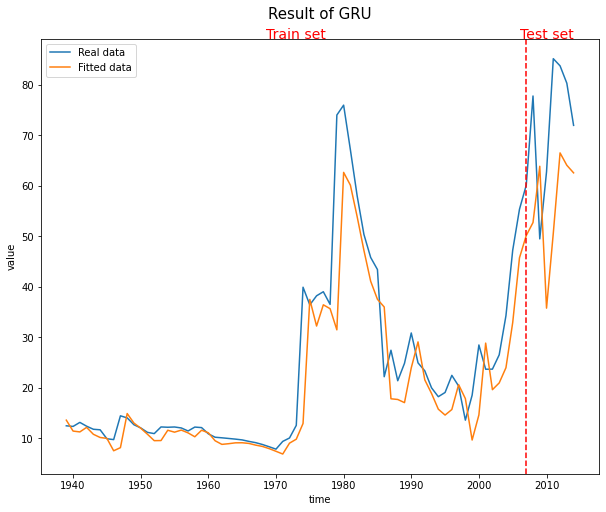

In [48]:
'''
与前端交互的代码
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim

def getdata(country="Afghanistan",feature_name="oil_price",start=1934,tail=2014):
    '''
    返回: data，维度是(总的时间步长, 特征数量)，其中特征数量等于一个时间步里面的向量长度；
    '''
    data = pd.read_csv('./data.csv')
    x = data[(start<=data['year']) & (data['year']<=tail)&(data['country'] == country)]

    #x_train,x_test = split_train_test(x,0.8)
    return np.array(x['year']),np.array(x[feature_name]).reshape(-1,1)


#模型预测
def predict_RNN(net,x,num_steps,num_preds=0,input_size = 1):
    # x_test默认是一个一维len_x的时间序列，转换成batch_size * len_x * input_size = 1*len_x*1的tensor，是预测时候已知的前置信息；
    # num_preds，预测多少个时间段的信息，即在x后生成num_preds个时间步；
    # 思路：每次用训练样本等长的x_test片段来预测新的等长预测，
    #预测x_test内部的时间步时，只更新state，;预测然后只取第一个时间步更新到输入样本中
    n = len(x) #时间长度
    times = num_preds //num_steps + 1
    #需要预测的时间长度
    x = torch.tensor(x, dtype = torch.float32).reshape(1,-1,input_size)
    new_x = torch.zeros((n+num_preds,input_size)).reshape(1,-1,input_size)
    #num_steps = min(n,num_steps) #选择前置信息和
    y_test = torch.zeros(size=(1,n+times*num_steps,input_size))
    state = net.begin_state(batch_size = 1)
    for i in range(n-num_steps): #x_test内部预测, 3 1 2 3 4 5
        yhat,state = net(x[:,i:i+num_steps,:],state.detach()) # yhat的size是(batch_size*num_steps, input_size)
        #y_test[0,i+num_steps,:] = x[0,i+num_steps,:]
        y_test[0,i+num_steps,:] = yhat[-1,:]
        new_x[0,i+num_steps,:] = x[0,i+num_steps,:]
    
    for i in range(0,num_preds):
        yhat,state = net(new_x[:,n-num_steps+i:n+i,:],state.detach())
        y_test[0,n+i,:] = yhat[-1,:]
        new_x[0,n+i,:] = yhat[-1,:]
    return y_test


######模型预测#########
def predict(net,x,num_steps,num_preds=0,input_size = 1):
    # x_test默认是一个一维len_x的时间序列，转换成batch_size * len_x * input_size = 1*len_x*1的tensor，是预测时候已知的前置信息；
    # num_preds，预测多少个时间段的信息，即在x后生成num_preds个时间步；
    # 思路：每次用训练样本等长的x_test片段来预测新的等长预测，
    #预测x_test内部的时间步时，只更新state，;预测然后只取第一个时间步更新到输入样本中
    n = len(x) #时间长度
    x = torch.tensor(x, dtype = torch.float32).reshape(1,-1,input_size)
    num_steps = min(n,num_steps) #选择前置信息和
    y_test = torch.zeros(x.shape)
    state = net.begin_state(batch_size = 1)
    for i in range(n-num_steps): #x_test内部预测, 3 1 2 3 4 5
        yhat,state = net(x[:,i:i+num_steps,:],state.detach()) # yhat的size是(batch_size*num_steps, input_size)
        y_test[0,i+num_steps] = yhat[0]
    
    return y_test


##########可视化##########
def vis_data(year,x,output,train_test_rate= None):
    #可视化图形
    
    fig = plt.figure(figsize = (10,8))
    plt.plot(year,x,label='Real data') #画原数据曲线
    plt.plot(year,output.detach().view(-1),label='Fitted data') #画拟合曲线
    
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    
    
    if train_test_rate: 
        #画辅助线
        ind = int(len(x)*train_test_rate)
        plt.axvline(x=year[ind], color='r', linestyle='--') #画辅助线
        # 在x轴顶部对应比例位置添加文本
        text_y_position = plt.gca().get_ylim()[1]  # 文本所在y轴位置
        plt.text((year[0]+year[ind])//2, text_y_position, 'Train set', ha='center',color="red",fontsize=14)
        plt.text((year[-1]+year[ind])//2, text_y_position, 'Test set', ha='center',color="red",fontsize=14)
    plt.title('Result of GRU',pad=20,fontsize=15)
    return fig


if __name__ == "__main__":
    year,x = getdata()
    # 加载保存的整个模型
    num_steps = 5
    train_test_rate=0.9
    #model_file = 'RNN'+"-"+country+'-'+feature+'.pth' 
    #net = torch.load('./system/engines/model/RNN/'+model_file)
    net = torch.load('./gru_model.pth')
    output = predict_RNN(net,x,num_steps,num_preds=0,input_size = 1)
    fig = vis_data(year[num_steps:],x[num_steps:],output.reshape(-1)[num_steps:len(year)].detach(),train_test_rate)
    


In [61]:
#####################定义LSTM模型(完整版)##########################
#定义LSTM模型 num_hiddens
class LSTMModel(nn.Module):
    #循环神经网络模型
    def __init__(self,input_size,num_hiddens,num_directions = 1, num_layers = 1):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_size, num_hiddens,num_layers,batch_first=True)
        #for p in self.rnn.parameters():
            #nn.init.normal_(p, mean=0.0, std=0.001)
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.output = nn.Linear(self.num_hiddens,self.input_size)#设计输出层

    def forward(self,X,state):
        h,c = state
        Y,state = self.lstm(X,(h,c)) 
        Y = Y.reshape(-1,self.num_hiddens)
        output = self.output(Y)
        return output,state
    
    def begin_state(self,batch_size = 1):
        return (torch.zeros(size = (self.num_layers*self.num_directions,batch_size,self.num_hiddens)),
                torch.zeros(size = (self.num_layers*self.num_directions,batch_size,self.num_hiddens)))
    
#模型训练
def train_epoch(net,x_train,num_epochs,batch_size,num_steps,lr=0.001):
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr)
    l = [] #用来绘制损失函数
    #训练
    for epoch in range(num_epochs):
        train_iter = seq_data_iter_random(x_train,batch_size,num_steps) #一个RNN的输入长度
        for X,Y in train_iter:
            optimizer.zero_grad()
            state = net.begin_state(batch_size = batch_size)
            output,state = net(X,state)
            loss = criterion(output,Y.reshape(-1,1))
            loss.backward()
            optimizer.step()
        ##报loss
        #if (epoch+1) % 100 == 0:
            #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        l.append(loss.item())
        
    ##############################绘制损失函数#################################
    #plt.plot(l,'r')
    #plt.xlabel('Epochs')
    #plt.ylabel('loss')

    
    return net



#模型预测
def predict(net,x,num_steps,num_preds=0,input_size = 1):
    # x_test默认是一个一维len_x的时间序列，转换成batch_size * len_x * input_size = 1*len_x*1的tensor，是预测时候已知的前置信息；
    # num_preds，预测多少个时间段的信息，即在x后生成num_preds个时间步；
    # 思路：每次用训练样本等长的x_test片段来预测新的等长预测，
    #预测x_test内部的时间步时，只更新state，;预测然后只取第一个时间步更新到输入样本中
    n = len(x) #时间长度
    times = num_preds //num_steps + 1
    #需要预测的时间长度
    x = torch.tensor(x, dtype = torch.float32).reshape(1,-1,input_size)
    new_x = torch.zeros((n+num_preds,input_size)).reshape(1,-1,input_size)
    #num_steps = min(n,num_steps) #选择前置信息和
    y_test = torch.zeros(size=(1,n+times*num_steps,input_size))
    state = net.begin_state(batch_size = 1)
    for i in range(n-num_steps): #x_test内部预测, 3 1 2 3 4 5
        yhat,state = net(x[:,i:i+num_steps,:],state.detach()) # yhat的size是(batch_size*num_steps, input_size)
        #y_test[0,i+num_steps,:] = x[0,i+num_steps,:]
        y_test[0,i+num_steps,:] = yhat[-1,:]
        new_x[0,i+num_steps,:] = x[0,i+num_steps,:]
    
    for i in range(0,num_preds):
        yhat,state = net(new_x[:,n-num_steps+i:n+i,:],state.detach())
        y_test[0,n+i,:] = yhat[-1,:]
        new_x[0,n+i,:] = yhat[-1,:]

    '''
    for i in range(0,times):
        yhat,state = net(y_test[:,n+i-num_steps:n+i,:],state.detach())
        y_test[0,n+i:n+i+num_steps,:] = yhat    
    '''
    
    return y_test

def predict_LSTM(net,x,num_steps,num_preds=0,input_size = 1):
    # x_test默认是一个一维len_x的时间序列，转换成batch_size * len_x * input_size = 1*len_x*1的tensor，是预测时候已知的前置信息；
    # num_preds，预测多少个时间段的信息，即在x后生成num_preds个时间步；
    # 思路：每次用训练样本等长的x_test片段来预测新的等长预测，
    #预测x_test内部的时间步时，只更新state，;预测然后只取第一个时间步更新到输入样本中
    n = len(x) #时间长度
    times = num_preds //num_steps + 1
    #需要预测的时间长度
    x = torch.tensor(x, dtype = torch.float32).reshape(1,-1,input_size)
    new_x = torch.zeros((n+num_preds,input_size)).reshape(1,-1,input_size)
    #num_steps = min(n,num_steps) #选择前置信息和
    y_test = torch.zeros(size=(1,n+times*num_steps,input_size))
    state = net.begin_state(batch_size = 1)
    for i in range(n-num_steps): #x_test内部预测, 3 1 2 3 4 5
        yhat,state = net(x[:,i:i+num_steps,:],(state[0].detach(),state[1].detach())) # yhat的size是(batch_size*num_steps, input_size)
        #y_test[0,i+num_steps,:] = x[0,i+num_steps,:]
        y_test[0,i+num_steps,:] = yhat[-1,:]
        new_x[0,i+num_steps,:] = x[0,i+num_steps,:]
    
    for i in range(0,num_preds):
        yhat,state = net(new_x[:,n-num_steps+i:n+i,:],state.detach())
        y_test[0,n+i,:] = yhat[-1,:]
        new_x[0,n+i,:] = yhat[-1,:]
    return y_test
        
##########可视化##########
def vis_data(year,x,output,train_test_rate= None):
    #可视化图形
    
    fig = plt.figure(figsize = (10,8))
    plt.plot(year,x,label='Real data') #画原数据曲线
    plt.plot(year,output.detach().view(-1),label='Fitted data') #画拟合曲线
    
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    
    
    if train_test_rate: 
        #画辅助线
        ind = int(len(x)*train_test_rate)
        plt.axvline(x=year[ind], color='r', linestyle='--') #画辅助线
        # 在x轴顶部对应比例位置添加文本
        text_y_position = plt.gca().get_ylim()[1]  # 文本所在y轴位置
        plt.text((year[0]+year[ind])//2, text_y_position, 'Train set', ha='center',color="red",fontsize=14)
        plt.text((year[-1]+year[ind])//2, text_y_position, 'Test set', ha='center',color="red",fontsize=14)
    plt.title('Result of LSTM',pad=20,fontsize=15)
    return fig


'''
#预测模型 :先根据已有的信息，预测接下来的信息
def predict(net,x_test,num_prediction):
    # x_test默认是一个一维num_steps的时间序列，转换成batch_size * num_steps * input_size = 1*num_steps*1的tensor
    #num_steps = len(x_test)
    outputs = [x_test[0]]
    #get_input = lambda: torch.tensor([outputs[-1]],dtype=torch.float32).reshape((1,1,1))
    state = net.begin_state(1)
    for y in x_test[1:]:
        _, state = net(get_input(),state)
        outputs.append(y)
    for _ in range(num_prediction):
        y,state = net(get_input(),state)
        outputs.append(y)
    return output'''

    

'\n#预测模型 :先根据已有的信息，预测接下来的信息\ndef predict(net,x_test,num_prediction):\n    # x_test默认是一个一维num_steps的时间序列，转换成batch_size * num_steps * input_size = 1*num_steps*1的tensor\n    #num_steps = len(x_test)\n    outputs = [x_test[0]]\n    #get_input = lambda: torch.tensor([outputs[-1]],dtype=torch.float32).reshape((1,1,1))\n    state = net.begin_state(1)\n    for y in x_test[1:]:\n        _, state = net(get_input(),state)\n        outputs.append(y)\n    for _ in range(num_prediction):\n        y,state = net(get_input(),state)\n        outputs.append(y)\n    return output'

In [62]:
# 获取数据
year,x = getdata()
year = np.array(year)
x_train,x_test = split_train_test(x,train_test_rate)

In [63]:

train_iter = seq_data_iter_random(x_train, batch_size, num_steps, num_delays=1)
X,Y = next(train_iter)
print('输入批的尺寸',X.shape)
net = LSTMModel(input_size,num_hiddens,num_layers=num_layers)
state = net.begin_state(batch_size)
#训练模型
net = train_epoch(net,x_train,num_epochs,batch_size,num_steps)



输入批的尺寸 torch.Size([2, 5, 1])


In [64]:
# 预测加上可视化模型
output = predict_LSTM(net,x,num_steps,num_preds=0,input_size = 1)
fig = vis_data(year[num_steps:],x[num_steps:],output.reshape(-1)[num_steps:len(year)].detach(),train_test_rate)
